# Mayank Raj 22BAI1118
Part B

In [1]:
import os
import pandas as pd

# Path to the main dataset folder
dataset_dir = '/kaggle/input/dataaaa/autosegment'

# List of classes (folders)
classes = os.listdir(dataset_dir)

# Prepare data for CSV
data = []

# Iterate through each class folder
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                data.append([img_path, class_name])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Image Directory', 'Class'])

# Save DataFrame to CSV
df.to_csv('image_data.csv', index=False)

print("CSV file 'image_data.csv' created successfully.")


CSV file 'image_data.csv' created successfully.


In [2]:
df.head()

,Image Directory,Class
0,/kaggle/input/dataaaa/autosegment/CO1/48.png,CO1
1,/kaggle/input/dataaaa/autosegment/CO1/37.png,CO1
2,/kaggle/input/dataaaa/autosegment/CO1/35.png,CO1
3,/kaggle/input/dataaaa/autosegment/CO1/11.png,CO1
4,/kaggle/input/dataaaa/autosegment/CO1/31.png,CO1


Found 560 validated image filenames belonging to 10 classes.
Found 140 validated image filenames belonging to 10 classes.


/tmp/ipykernel_31/3048483819.py:44: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 459ms/step - accuracy: 0.2085 - loss: 2.4206 - val_accuracy: 0.0000e+00 - val_loss: 4.6606
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3202 - loss: 1.8718 - val_accuracy: 0.0214 - val_loss: 3.7195
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3902 - loss: 1.7005 - val_accuracy: 0.0000e+00 - val_loss: 3.9768
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3987 - loss: 1.5575 - val_accuracy: 0.0143 - val_loss: 3.8391
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.4342 - loss: 1.5540 - val_accuracy: 0.0571 - val_loss: 3.9316
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.4138 - loss: 1.5725 - val_accuracy: 0.1214 - val_loss: 3.7742
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4526 - loss: 1.4607 - val_accuracy: 0.0000e+00 - val_loss: 4.3233
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.4543 - loss: 1.3831 - val_accuracy: 0.1929

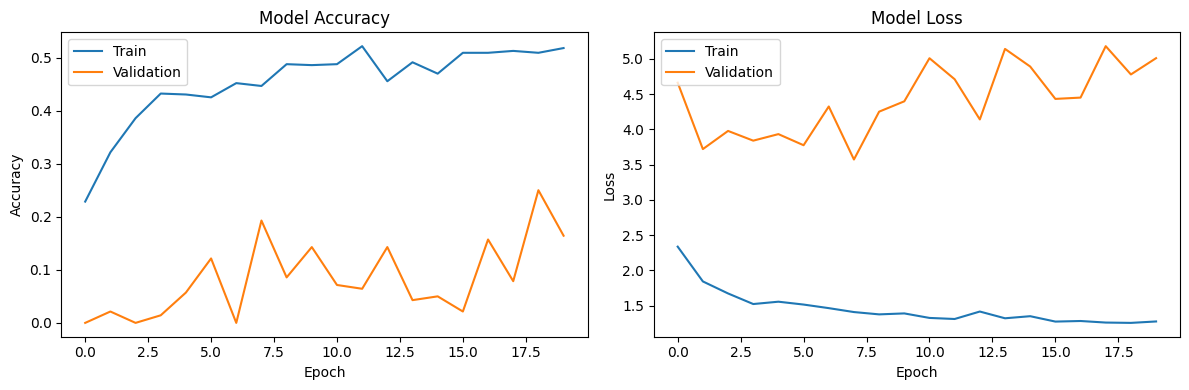

In [21]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('image_data.csv')

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Data generators
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image Directory',
    y_col='Class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image Directory',
    y_col='Class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load the pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and checkpointing
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Load the best model saved during training
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluate the best model
loss, accuracy = best_model.evaluate(validation_generator)
print(f'Validation Accuracy of the Best Model: {accuracy * 100:.2f}%')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
